Load all necessary imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import cv2
import matplotlib.pyplot as plt
import h5py

# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

2024-03-07 13:48:02.375109: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 13:48:02.770650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 13:48:02.770788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 13:48:02.828173: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 13:48:02.949081: I tensorflow/core/platform/cpu_feature_guar

Data Loading

In [2]:
with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)

Data Normalization

In [4]:
image_normalized = (images+1)/9.26 # Normalize images and add noise


# Normalize bounding boxes
normalized_boxes = boxes / [1,64,64,64,64]

In [29]:
from tensorflow.keras import layers, models



input_shape = (64, 64, 1)
num_classes = 280
num_coordinates = 4

images_np = image_normalized
#images_np = tf.expand_dims(images_np, axis=-1)
probabilities = np.array(normalized_boxes[:, :,:-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)

dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))


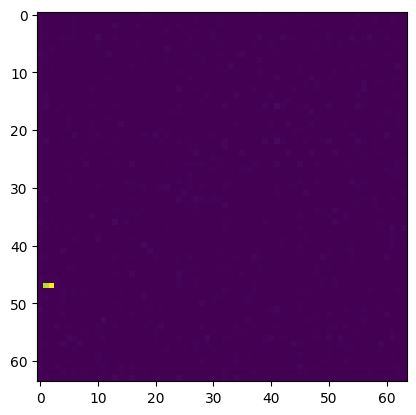

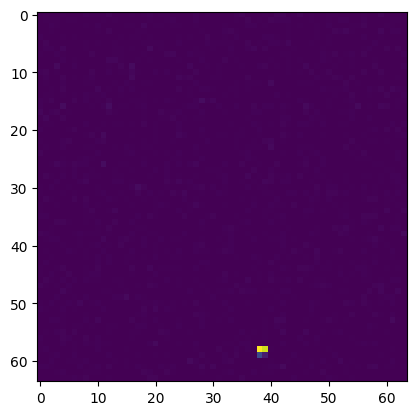

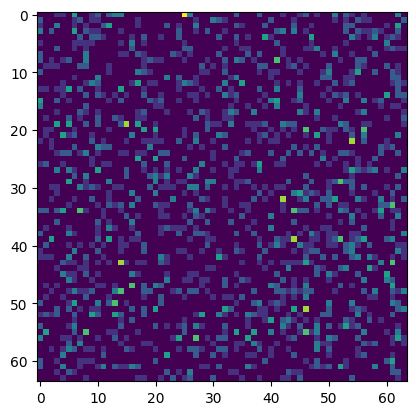

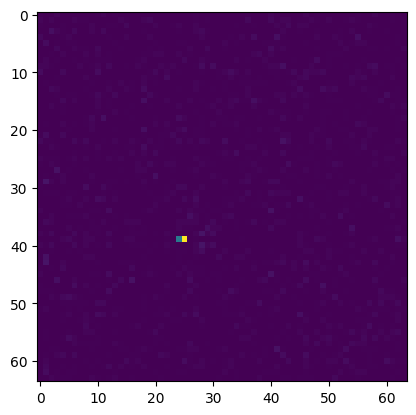

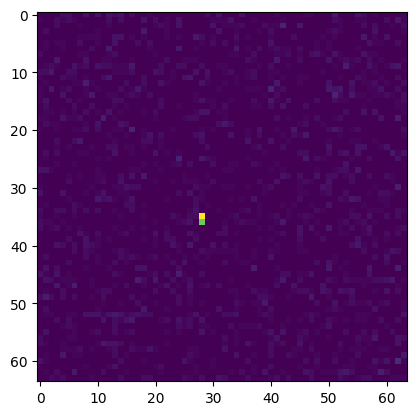

In [30]:
# dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for i, element in enumerate(dataset):
  if i ==5:
      break
  img, dict_ = element
  prob, box = dict_['x_prob_reshape'], dict_['x_boxes_reshape']
#   print(element)
  plt.imshow(img)
  plt.show()




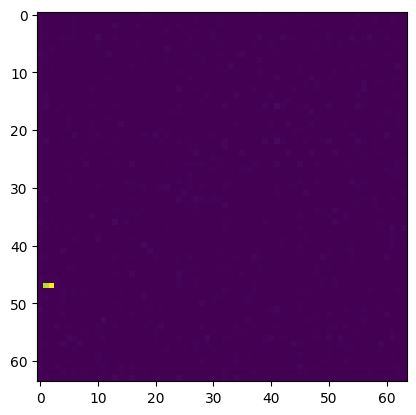

In [12]:
plt.imshow(images_np[0])

Check to see if 

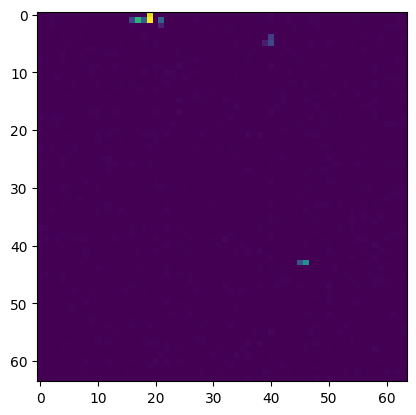

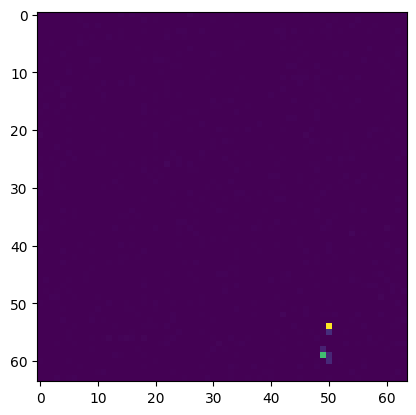

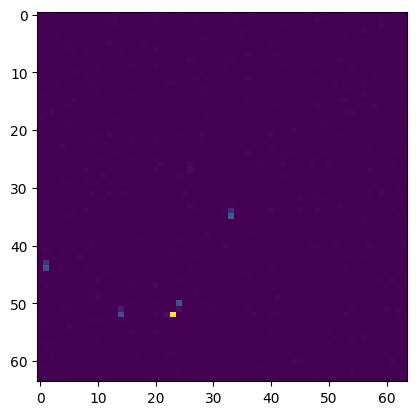

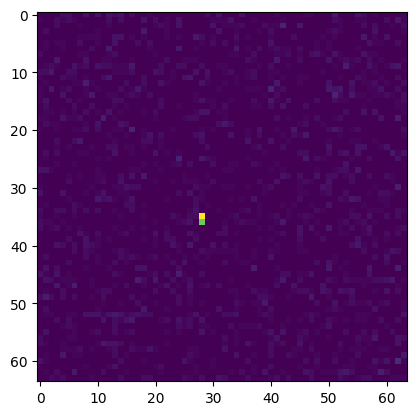

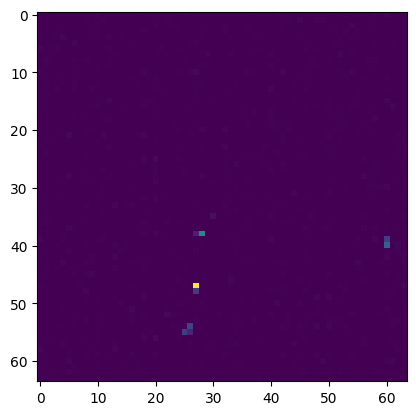

In [31]:

# dataset = dataset.batch(400)
dataset=dataset.shuffle(buffer_size=500, reshuffle_each_iteration=True) 
# dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
for i, element in enumerate(dataset):
  if i ==5:
      break
  img, dict_ = element
  prob, box = dict_['x_prob_reshape'], dict_['x_boxes_reshape']
#   print(element)
  plt.imshow(img)
  plt.show()

In [14]:
plt.imshow(dataset[0])

TypeError: '_TensorSliceDataset' object is not subscriptable

In [16]:
dataset[0]

TypeError: '_TensorSliceDataset' object is not subscriptable

In [ ]:

x_input = layers.Input(shape=input_shape)

x = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 

x = layers.Conv2D(64, kernel_size=5, padding='same', activation='relu')(x)
x = layers.BatchNormalization()(x)  

x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(128, kernel_size=5, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 32x32

x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
#x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x)  # size: 16x16

x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(512, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x

x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) # size: 8x8x


x = layers.Flatten()(x)
# Bounding box output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])


optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)  # Consider adjusting based on performance





model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics=['accuracy'] )
num_epochs = 1000


In [7]:
model.fit(dataset, epochs=num_epochs)

Epoch 1/1000
1/1 [==============================] - 55s 55s/step - loss: 1.1298 - x_prob_reshape_loss: 0.8435 - x_boxes_reshape_loss: 0.2863 - x_prob_reshape_accuracy: 0.4969 - x_boxes_reshape_accuracy: 0.2438
Epoch 2/1000
1/1 [==============================] - 0s 401ms/step - loss: 1.0086 - x_prob_reshape_loss: 0.7319 - x_boxes_reshape_loss: 0.2767 - x_prob_reshape_accuracy: 0.5726 - x_boxes_reshape_accuracy: 0.2448
Epoch 3/1000
1/1 [==============================] - 0s 418ms/step - loss: 0.9202 - x_prob_reshape_loss: 0.6510 - x_boxes_reshape_loss: 0.2692 - x_prob_reshape_accuracy: 0.6460 - x_boxes_reshape_accuracy: 0.2462
Epoch 4/1000
1/1 [==============================] - 0s 402ms/step - loss: 0.8458 - x_prob_reshape_loss: 0.5831 - x_boxes_reshape_loss: 0.2626 - x_prob_reshape_accuracy: 0.7133 - x_boxes_reshape_accuracy: 0.2478
Epoch 5/1000
1/1 [==============================] - 0s 400ms/step - loss: 0.7769 - x_prob_reshape_loss: 0.5208 - x_boxes_reshape_loss: 0.2561 - x_prob_reshap

In [37]:
model.save('model5zeroes_justvalidation.h5')


/home/m3-learning/anaconda3/envs/tiny_yolo/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [8]:
loaded_model = tf.keras.models.load_model('model5zeroes.h5')


In [23]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))
dataset = dataset.batch(10000)
inputs,targets = next(iter(dataset))
output = model.predict(inputs)

13/13 [==============================] - 0s 14ms/step


In [29]:
targets['x_boxes_reshape'][3]

<tf.Tensor: shape=(1, 280, 4), dtype=float64, numpy=
array([[[0.609375, 0.375   , 0.609375, 0.390625],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        ...,
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ],
        [0.      , 0.      , 0.      , 0.      ]]])>

In [30]:
output[1][3]

array([[[0.608321  , 0.37544996, 0.60048765, 0.39058328],
        [0.04114862, 0.04350902, 0.03601224, 0.03161911],
        [0.02564523, 0.01642084, 0.0225285 , 0.02103107],
        ...,
        [0.00356427, 0.00505332, 0.00641309, 0.00199714],
        [0.00315547, 0.00425017, 0.00402874, 0.00372648],
        [0.01020624, 0.01075523, 0.00156876, 0.00145441]]], dtype=float32)

In [36]:
import tensorflow as tf

r = np.random.randint(0,100)
tensor1 = tf.constant(targets['x_boxes_reshape'][r], dtype=tf.float64)

tensor2 = tf.constant(output[1][r], dtype=tf.float32)


tensor2 = tf.cast(tensor2, tf.float64)


mse_loss_fn = tf.keras.losses.MeanSquaredError()
mse_loss = mse_loss_fn(tensor1, tensor2)

print("MSE Loss:", mse_loss.numpy())


MSE Loss: 4.790622258574036e-05


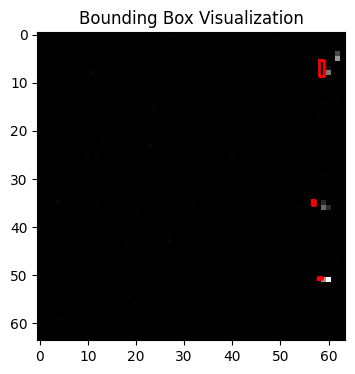

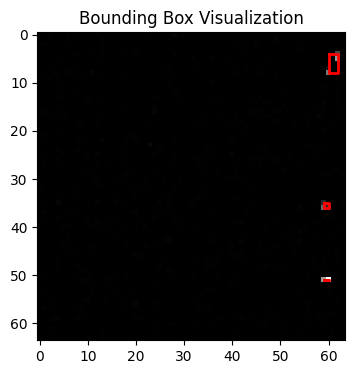

In [21]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,200)
# probabilities = tf.convert_to_tensor(output[0][t,:])

visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction
